# License Plate Recognition

In [ ]:
!pip install pytorch_lightning==1.9.5 torchmetrics wandb transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 425.1 kB/s eta 0:00:00


In [ ]:
from itertools import groupby, islice
import os
from tqdm.auto import tqdm

import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
import torchvision.transforms as transforms
from torchmetrics import ExactMatch, CharErrorRate, ConfusionMatrix
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import WandbLogger
from torch.optim import AdamW

import numpy as np
import pandas as pd
import sys

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import get_cosine_schedule_with_warmup


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
class CFG:
    wandb = True
    model = 'CRNN-with-scheduler-16prec'
    batch_size = 512
    learning_rate = 3e-4
    eps=1e-6
    betas=(0.9, 0.999)
    num_cycles = 0.5

In [ ]:
def seed_everything(seed):
    import random
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=42)

In [ ]:
if CFG.wandb:

    import wandb

    try:
        if 'google.colab' in sys.modules:
            wandb.login()
        else:
            from kaggle_secrets import UserSecretsClient
            user_secrets = UserSecretsClient()
            secret_value_0 = user_secrets.get_secret("wandb_api")
            wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. \
        Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='expv6',
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

## Dataset:

Рассмотрим те шаманские методы, что нужно будет сейчас использовать
1. Для начала стоит определить, что именно может входить в любой дорожный знак - для этого мы используем очень сложный инструмент под названием глаза.
После просмотра некоторых знаков (и опирания на то, что все знаки должны подчиняться одной системе построения), можем вывести некоторые правила:
- в конце всегда 3 цифры
- в начале иероглиф и буква
- между первыми 2 символами и остальными всегда разделитель (то ли точка, то ли тире - я в данном случае в кач-ве разделителя буду использовать тире)
Таким образом, в датасет могут входить некоторые английские буквы, цифры и некоторые иероглифы
2. Нужно найти все буквы, иероглифы и цифры, что могут быть в автомобильном номере

Итоговый план, что нужно делать
1. Скачать датасет и распаковать
2. Пройтись по всем номерам, распарсить их и посмортеть, какие символы могут быть в номере
3. Создать необходимый класс словаря

Скачиваем:

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# !unzip drive/MyDrive/lab/CCPD2019-dl1.zip

In [ ]:
img_dir = "CCPD2019-dl1/"

Все символы, что могут быть, и класс словаря:

In [ ]:
blank = ["-"]
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
numbers = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [ ]:
class Dictionary:
    def __init__(self):
        self.char2idx = {}
        self.idx2char = []

    def add_char(self, char: str):
        if char not in self.char2idx:
            self.idx2char.append(char)
            self.char2idx[char] = len(self.idx2char) - 1

    def __len__(self):
        return len(self.idx2char)

In [ ]:
dictionary = Dictionary()

for char in blank + provinces + alphabets + numbers:
    dictionary.add_char(char)

In [ ]:
class LabelConverter:
    def __init__(self, dictionary: Dictionary):
        self.dictionary = dictionary

    def encode(self, label: str):
        return torch.LongTensor([self.dictionary.char2idx[char] for char in label])

    def decode(
        self,
        sequence,
        prediction = True,
        blank = 0,
    ):

        if prediction:
            sequence = [int(k) for k, _ in groupby(sequence)]
        return "".join(
            self.dictionary.idx2char[idx] for idx in sequence if idx != blank
        )

In [ ]:
label_converter = LabelConverter(dictionary)

In [ ]:
class LicencePlateDataset(Dataset):
    def __init__(
        self,
        img_dir,
        dictionary,
        img_size = (128, 32),
        train = True,
        transform = None,
    ):
        super().__init__()

        self.img_dir = os.path.join(img_dir, "train" if train else "test")
        self.images = [
            os.path.join(self.img_dir, img_filename)
            for img_filename in os.listdir(self.img_dir)
        ]
        self.labels = [img_filename.split("-")[-1][:-4] for img_filename in self.images]
        self.dictionary = dictionary
        self.img_size = img_size  # (width, height)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx: int):
        img = cv2.imread(self.images[idx])
        img = cv2.resize(img, self.img_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        label_encoded = torch.LongTensor(
            [self.dictionary.char2idx[char] for char in label]
        )
        return img, label_encoded

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

train_dataset = LicencePlateDataset(
    img_dir=img_dir,
    dictionary=dictionary,
    train=True,
    transform=transform
)

test_dataset = LicencePlateDataset(
    img_dir=img_dir,
    dictionary=dictionary,
    train=False,
    transform=transform
)


n_val = int(0.05 * len(train_dataset))
n_train = len(train_dataset) - n_val
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])

В пункте выше я пробовал заменить random_split на sklearn-овский train_test_split, но он по времени просто не хотел работать - поэтому я зафиксировал сид и оставил то, что было раньше

In [ ]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=CFG.batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=CFG.batch_size,
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

In [ ]:
CFG.num_train_steps = len(train_dataloader)
CFG.num_warmup_steps = 0

## Архитектура (CRNN)

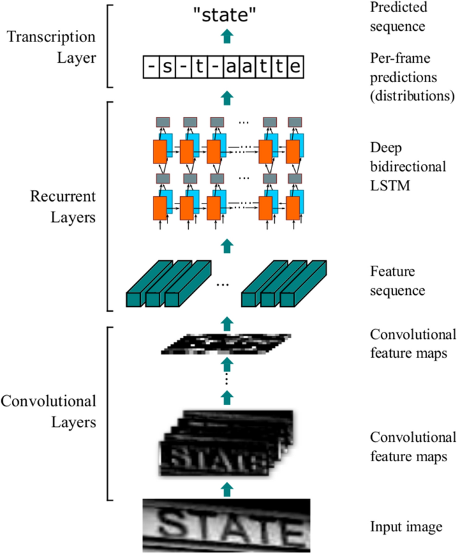  

Путем поиска доп информации нашел оригинальную статью по CRNN - будем заниматься имплементацией

Ссылка на статью: https://arxiv.org/pdf/1507.05717.pdf

In [ ]:
class BidirectionalLSTM(nn.Module):
    def __init__(
        self,
        dictionary_size,
        ninp,
        nhid,
        nlayers,
    ):
        super().__init__()
        self.rnn = nn.LSTM(
            input_size=ninp, hidden_size=nhid, num_layers=nlayers, bidirectional=True
        )
        self.decoder = nn.Linear(2 * nhid, dictionary_size)

        self.dictionary_size = dictionary_size

    def forward(self, input):
        output, _ = self.rnn(input)
        seq_len, batch_size, _ = output.size()
        decoded = self.decoder(output)
        decoded = decoded.view(seq_len, batch_size, self.dictionary_size)
        return decoded


class CRNN(nn.Module):
    def conv_layer(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: int,
        padding: int,
        batch_norm = False,
    ):
        layers = [
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                padding=padding,
                bias=not batch_norm
            )
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(num_features=out_channels))
        layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def __init__(self, dictionary_size: int):
        super().__init__()

        self.cnn = nn.Sequential(
            self.conv_layer(
                in_channels=1,
                out_channels=64,
                kernel_size=3,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_layer(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=2, stride=2),
            self.conv_layer(
                in_channels=128,
                out_channels=256,
                kernel_size=3,
                padding=1
            ),
            self.conv_layer(
                in_channels=256,
                out_channels=256,
                kernel_size=3,
                padding=1
            ),
            nn.MaxPool2d(kernel_size=(1, 2), stride=2),
            self.conv_layer(
                in_channels=256,
                out_channels=512,
                kernel_size=3,
                padding=1,
                batch_norm=True
            ),
            self.conv_layer(
                in_channels=512,
                out_channels=512,
                kernel_size=3,
                padding=1,
                batch_norm=True
            ),
            nn.MaxPool2d(
                kernel_size=(1, 2),
                stride=(2, 1),
                padding=(0, 1)
            ),
            self.conv_layer(
                in_channels=512,
                out_channels=512,
                kernel_size=2,
                padding=0,
                batch_norm=True
            )
        )

        self.rnn = BidirectionalLSTM(
            dictionary_size=dictionary_size, ninp=512, nhid=256, nlayers=2
        )

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        cnn_out = self.cnn(input)
        map_to_sequence = cnn_out.squeeze(2).permute(2, 0, 1)
        output = self.rnn(map_to_sequence)

        return output

In [ ]:
model = CRNN(dictionary_size=len(dictionary)).to(device)
print(model)

CRNN(
  (cnn): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (5): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (6): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
  

## Training

Выбранные метрики решения:
- ExactMatch (в кач-ве accuracy)
- CER

In [ ]:
CFG.num_train_steps

372

In [ ]:
class OCRModule(pl.LightningModule):
    def __init__(
        self,
        learning_rate,
        dictionary_size,
        label_converter,
        config
    ):
        super().__init__()

        self.save_hyperparameters("learning_rate", "dictionary_size")

        self.config = config

        self.learning_rate = learning_rate
        self.dictionary_size = dictionary_size
        self.label_converter = label_converter

        self.model = CRNN(dictionary_size=dictionary_size)
        self.criterion = nn.CTCLoss()
        self.test_accuracy = ExactMatch(
            task="multiclass", num_classes=dictionary_size, ignore_index=0
        )
        self.test_char_error_rate = CharErrorRate()
        self.test_confusion_matrix = ConfusionMatrix(
            task="multiclass", num_classes=dictionary_size, ignore_index=0
        )

    def forward(self, images):
        return self.model(images)

    def step(
        self,
        stage,
        batch,
        batch_idx
    ):
        images, targets = batch
        logits = self(images)
        log_probs = F.log_softmax(logits, dim=-1)

        T, N, C = log_probs.size()

        input_lengths = torch.LongTensor([T for _ in range(N)])
        target_lengths = torch.LongTensor([targets.size(-1) for _ in range(N)])

        loss = self.criterion(log_probs, targets, input_lengths, target_lengths)

        return {"loss": loss, "logits": logits}

    def training_step(
        self,
        batch,
        batch_idx
    ):
        results = self.step("train", batch, batch_idx)
        self.log(
            "train_loss", results["loss"], on_step=False, on_epoch=True, prog_bar=True
        )
        return results["loss"]

    def validation_step(
        self,
        batch,
        batch_idx
    ):
        results = self.step("val", batch, batch_idx)
        self.log("val_loss", results["loss"], prog_bar=True)
        return results["loss"]

    def test_step(
        self,
        batch,
        batch_idx
    ):
        results = self.step("test", batch, batch_idx)
        self.log("test_loss", results["loss"], prog_bar=True)

        batch_size = batch[0].size(0)
        targets = batch[1]
        targets_decoded = [
            self.label_converter.decode(targets[i][:], prediction=False)
            for i in range(batch_size)
        ]

        preds = results["logits"].argmax(-1)  # seq_len x batch_size
        preds = preds.permute(1, 0)  # batch_size x seq_len
        preds_decoded = [
            self.label_converter.decode(preds[i][:]) for i in range(batch_size)
        ]

        preds_encoded = pad_sequence(
            [self.label_converter.encode(label) for label in preds_decoded],
            batch_first=True,
        ).to(self.device)

        if preds_encoded.size(1) != 7:
            targets = F.pad(targets, (0, preds_encoded.size(1) - 7), "constant", 0).to(self.device)

        self.test_accuracy.update(preds_encoded, targets)
        self.log("test_acc", self.test_accuracy, prog_bar=True)


        self.test_char_error_rate.update(preds_decoded, targets_decoded)
        self.log("test_char_error_rate", self.test_char_error_rate, prog_bar=True)

        return {"loss": results["loss"], "outputs": preds_encoded, "targets": targets}

    def test_epoch_end(self, outs):
        outputs, targets = [], []
        for i in range(len(outs)):
            batch_size = outs[i]["outputs"].size(0)
            for j in range(batch_size):
                outputs.append(outs[i]["outputs"][j][:])
                targets.append(outs[i]["targets"][j][:])

        outputs_padded = pad_sequence(outputs, batch_first=True).to(
            self.device
        )
        targets_padded = pad_sequence(targets, batch_first=True).to(
            self.device
        )

        self.test_confusion_matrix(outputs_padded, targets_padded)
        computed_conf_mat = (
            self.test_confusion_matrix.compute().cpu().numpy().astype(int)
        )

        df = pd.DataFrame(
            computed_conf_mat,
            index=list(dictionary.char2idx.keys()),
            columns=list(dictionary.char2idx.keys()),
        )

        with pd.option_context("display.max_rows", None, "display.max_columns", None):
            display(df)

        plt.figure(figsize=(35, 35))
        fig = sns.heatmap(df, annot=True, cmap="Spectral").get_figure()
        plt.xlabel("Predicted", fontsize=18)
        plt.ylabel("Actual", fontsize=18)
        plt.close(fig)


    def configure_optimizers(self):
        optimizer = AdamW(
            self.parameters(),
            lr=self.learning_rate,
            eps=self.config.eps,
            betas=self.config.betas
        )

        scheduler = get_cosine_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.config.num_warmup_steps,
                num_training_steps=self.config.num_train_steps,
                num_cycles=self.config.num_cycles
        )

        return [optimizer], [scheduler]

In [ ]:
path_dir = '/content/drive/MyDrive/lab/'

In [ ]:
module = OCRModule(
    learning_rate=CFG.learning_rate,
    dictionary_size=len(dictionary),
    label_converter=label_converter,
    config=CFG
)
wandb_logger = WandbLogger(log_model='all')

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    save_top_k=1,
    dirpath=os.path.join(path_dir, "checkpoints"),
    filename="best_v"
)
trainer = pl.Trainer(
    accelerator='gpu',
    logger=wandb_logger,
    precision=16,
    max_epochs=20,
    callbacks=[checkpoint_callback]
)

trainer.fit(
    model=module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit None Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /content/drive/MyDrive/lab/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lig

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
trainer.test(model=module, dataloaders=test_dataloader, ckpt_path="best")

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/lab/checkpoints/best_v.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/lab/checkpoints/best_v.ckpt


Testing: 0it [00:00, ?it/s]

,-,皖,沪,津,渝,冀,晋,蒙,辽,吉,黑,苏,浙,京,闽,赣,鲁,豫,鄂,湘,粤,桂,琼,川,贵,云,藏,陕,甘,青,宁,新,警,学,O,A,B,C,D,E,F,G,H,J,K,L,M,N,P,Q,R,S,T,U,V,W,X,Y,Z,0,1,2,3,4,5,6,7,8,9
-,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
皖,0,9488,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
沪,0,1,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
津,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
渝,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
冀,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
晋,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
蒙,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
辽,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
吉,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 30358 (\N{CJK UNIFIED IDEOGRAPH-7696}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 27818 (\N{CJK UNIFIED IDEOGRAPH-6CAA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 27941 (\N{CJK UNIFIED IDEOGRAPH-6D25}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 28189 (\N{CJK UNIFIED IDEOGRAPH-6E1D}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 20864 (\N{CJK UNIFIED IDEOGRAPH-5180}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 26187 (\N{CJK UNIFIED IDEOGRAPH-664B}) missing from current font.
  fig.canvas.draw()
/usr

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9844984412193298     │
│   test_char_error_rate    │   0.002628834219649434    │
│         test_loss         │    0.01234703790396452    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.01234703790396452,
  'test_acc': 0.9844984412193298,
  'test_char_error_rate': 0.002628834219649434}]